In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
from datetime import datetime, timedelta
import calendar
from matplotlib.ticker import FormatStrFormatter

In [22]:
stations = np.load('../../first-stations.npy')
station_dict = {'10258500':'SC', '10259000':'SC', '10259200':'SC', '10343500':'SN', '11141280':'CC', 
                '11143000':'CC', '11148900':'CC', '11162500':'BA', '11176400':'BA', '11180500':'BA', 
                '11224500':'CC', '11253310':'CC', '11264500':'SN', '11266500':'SN', '11284400':'SN', 
                '11381500':'NC', '11451100':'NC', '11475560':'NC', '11522500':'NC', '11528700':'NC'}
order_stations=[10258500, 10259000, 10259200, 11162500, 11176400,
                10343500, 11264500, 11266500, 11284400, 11180500,
                11141280, 11143000, 11148900, 11224500, 11253310, 
                11381500, 11451100, 11475560, 11522500, 11528700,]

In [49]:
SMALL_SIZE=8; MEDIUM_SIZE=14; BIGGER_SIZE=18
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

## Compare hist and RCP

In [74]:
def compare_plot(climate_model):
    fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(16,15))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Exceedence (percentage)")
    plt.ylabel("Streamflow mm/day")
    for i in range(20):
        station = order_stations[i]
        hist = np.load('projection_dataset/'+str(station)+'-'+climate_model+'-hist.npy')
        sort = np.sort(np.clip(hist, a_min=1e-10, a_max=None), axis=None)[::-1]
        exceedence = np.arange(1.,len(sort)+1) / len(sort)
        fdc_hist = axs.flat[i].plot(exceedence*100, sort, label=climate_model+'-historical')
        projection = np.load('projection_dataset/'+str(station)+'-'+climate_model+'-RCP8.5.npy')
        sort = np.sort(np.clip(projection, a_min=1e-10, a_max=None), axis=None)[::-1]
        exceedence = np.arange(1.,len(sort)+1) / len(sort)
        fdc_proj = axs.flat[i].plot(exceedence*100, sort, label=climate_model+'-projection')
        axs.flat[i].set_xscale('log')
        axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
        # axs.flat[i].set_xlabel('Exceedence')
        # axs.flat[i].set_ylabel('Streamflow mm/day')
    handles, labels = axs.flat[i-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)  
    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.savefig(climate_model+'-FDC.eps')
    plt.show()

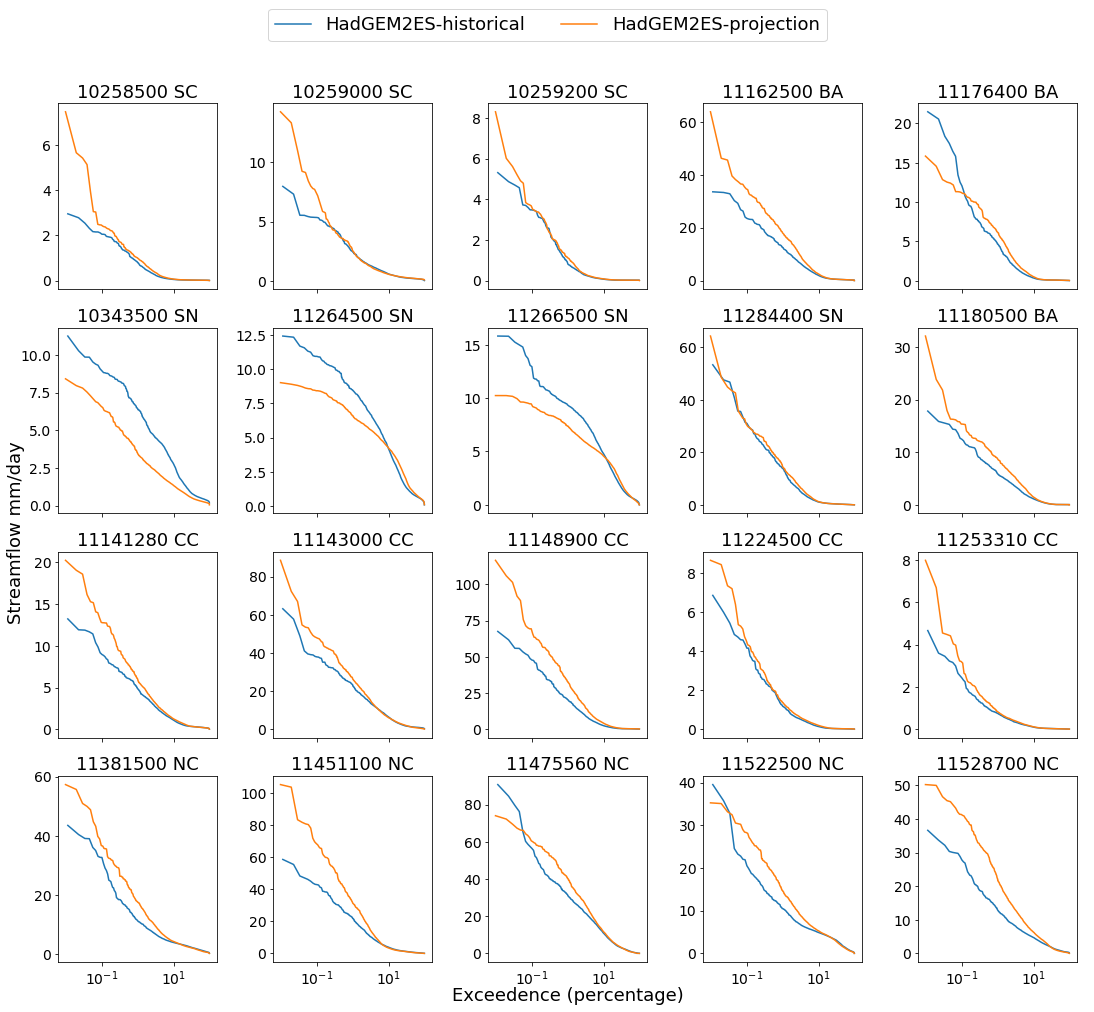

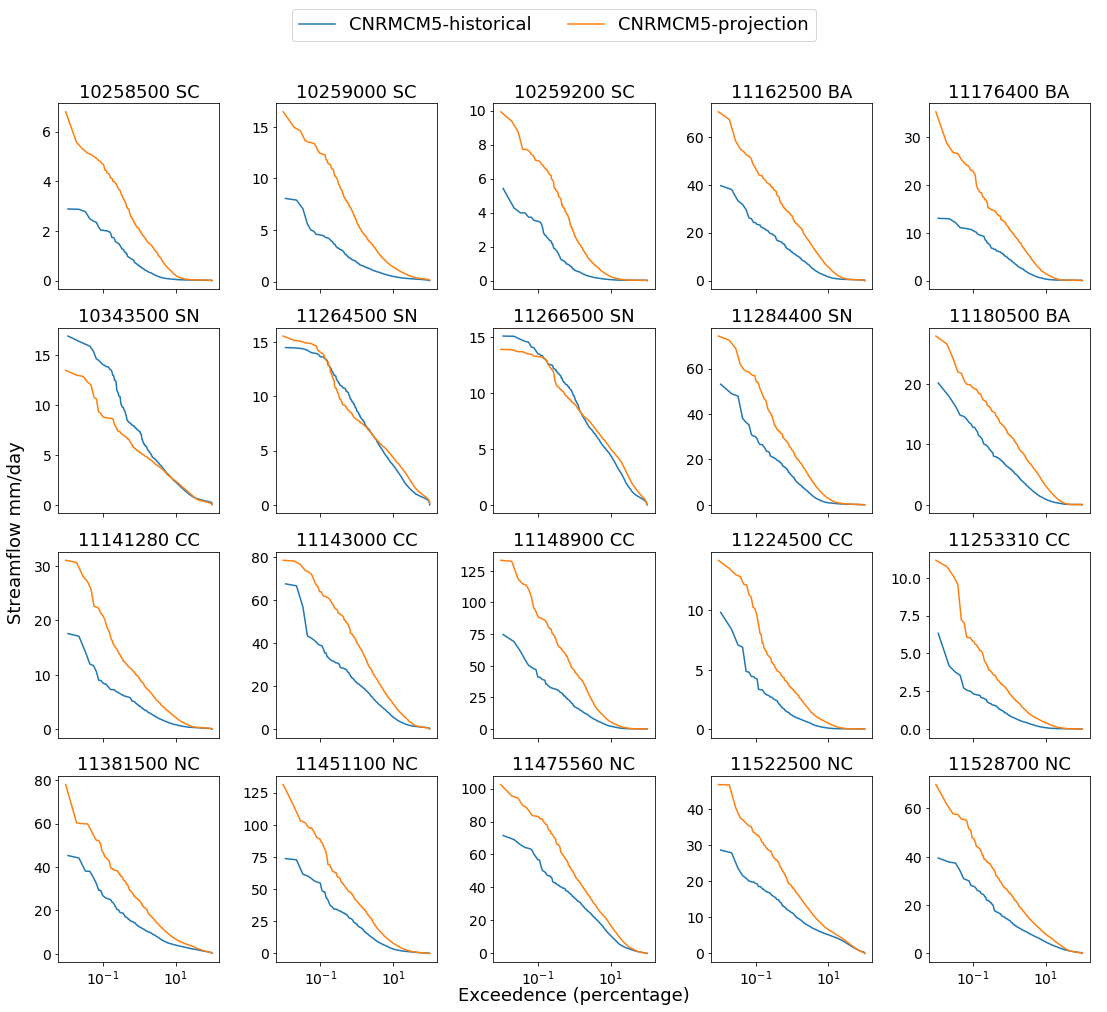

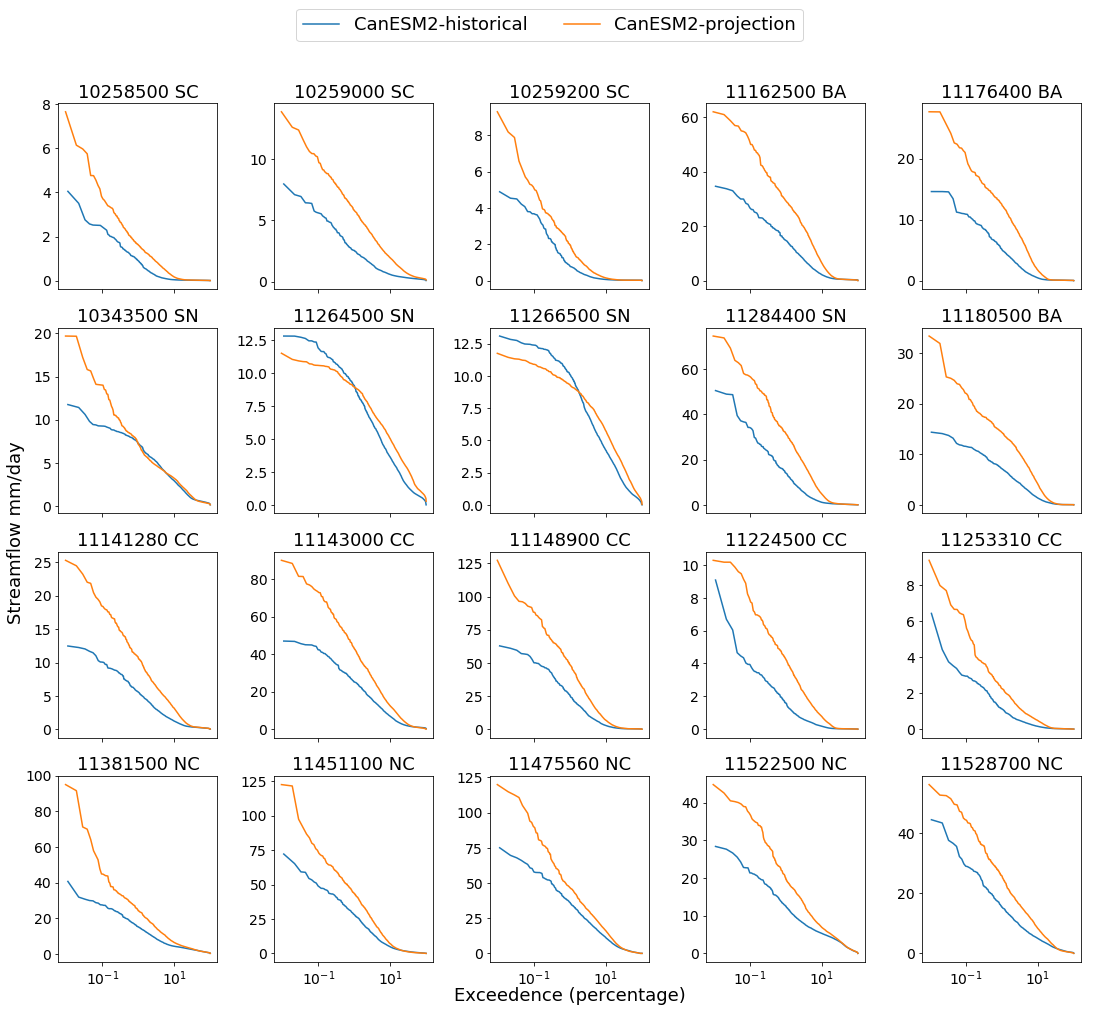

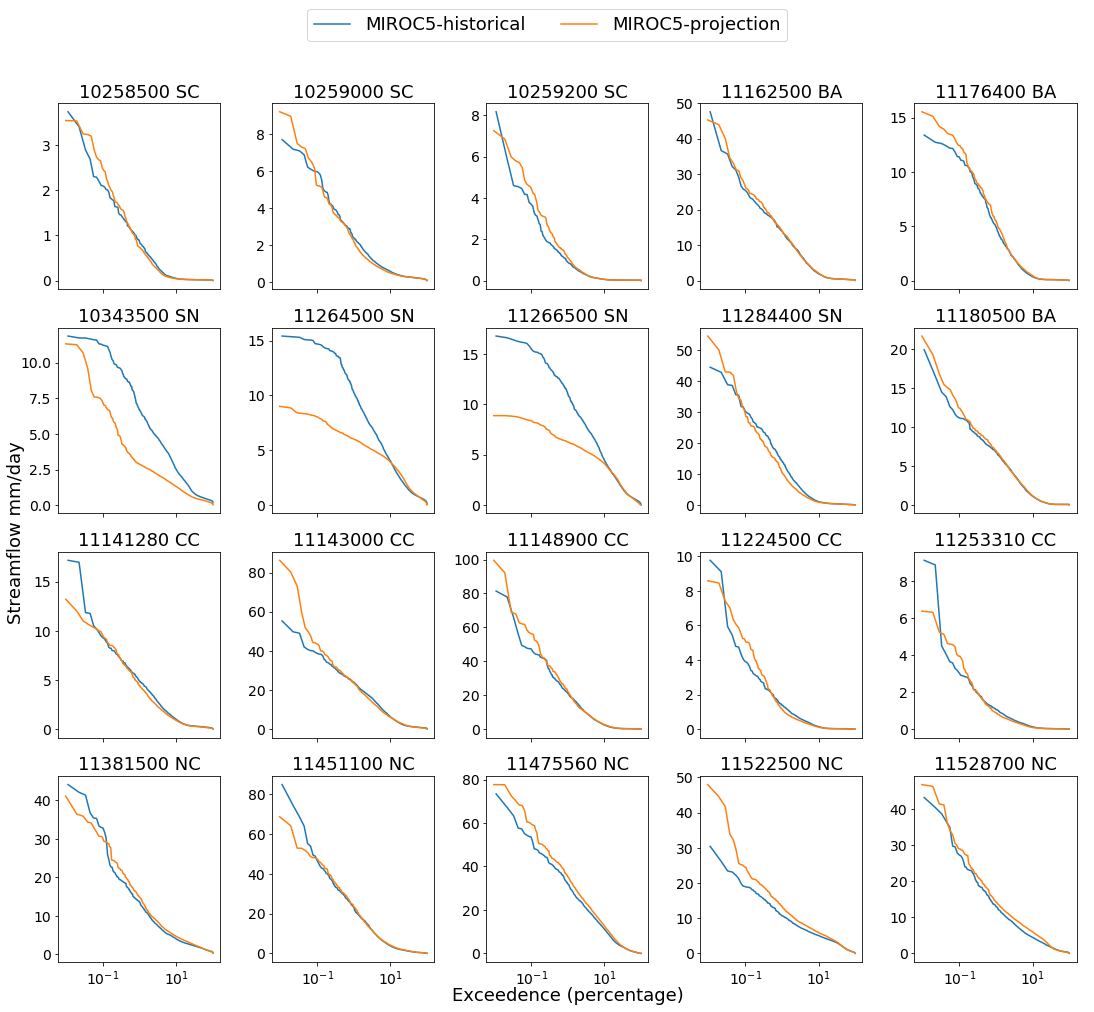

In [75]:
climate_models=['HadGEM2ES', 'CNRMCM5', 'CanESM2', 'MIROC5']
for climate_model in climate_models:
    compare_plot(climate_model)

## Climatology

In [8]:
date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/tmin_85_regrid_20.nc').variables['time']
date = np.array(date)
start = datetime(1900,1,1)
proj_date = [start+timedelta(t) for t in date]
print(proj_date[0], ' ', proj_date[-1])

2070-01-01 12:00:00   2099-12-31 12:00:00


In [9]:
def annual_mean(proj, date): ## exclude leap day
    l = len(date)-365
    year = np.zeros(365)
    out = np.zeros(365)
    for i in range(l):
        d = date[i+364]
        if (calendar.isleap(d.year)): ## it is leap year
            if (d.month==2) and (d.date==29):
                continue
            elif (d.month>2):
                day = d.timetuple().tm_yday-1
            else:
                day = d.timetuple().tm_yday
        else:
            day = d.timetuple().tm_yday
        year[day-1]+=1
        out[day-1]+=proj[i]
    return out, year

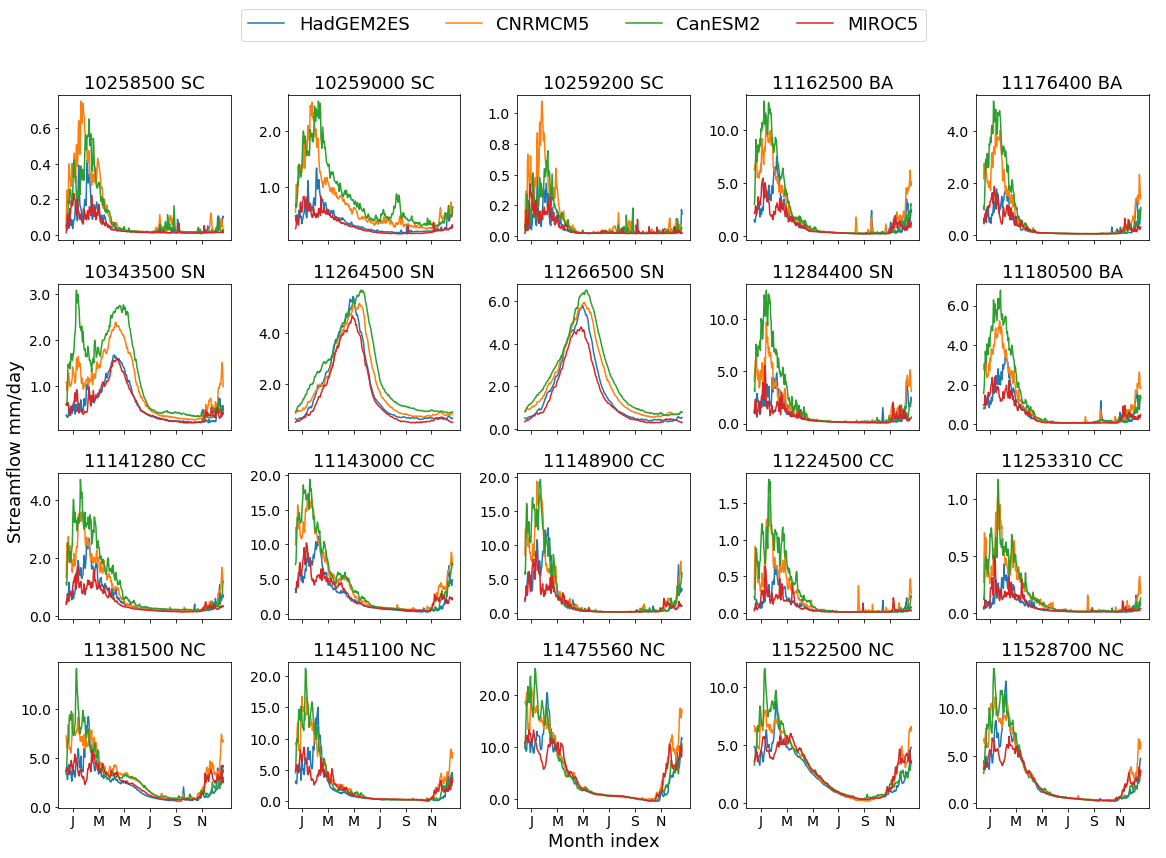

In [70]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Month index")
plt.ylabel("Streamflow mm/day")
months=[1,2,3,4,5,6,7,8,9,10,11,12]
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months=['J','F','M','A','M','J','J','A','S','O','N','D']
month_loc=[15+i*30 for i in range(12)]

for i in range(20):
    station = order_stations[i]
    for climate_model in climate_models:
        projection = np.load('projection_dataset/'+str(station)+'-'+climate_model+'-RCP8.5.npy')[1:]
        out, year = annual_mean(projection, proj_date)
        # print(year)
        annual = out/year
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.flat[i].plot(annual, label=climate_model)
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])
'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4) 
fig.tight_layout(rect=[0, 0.05, 1, 0.94])
fig.savefig('climatology-four-models.eps')

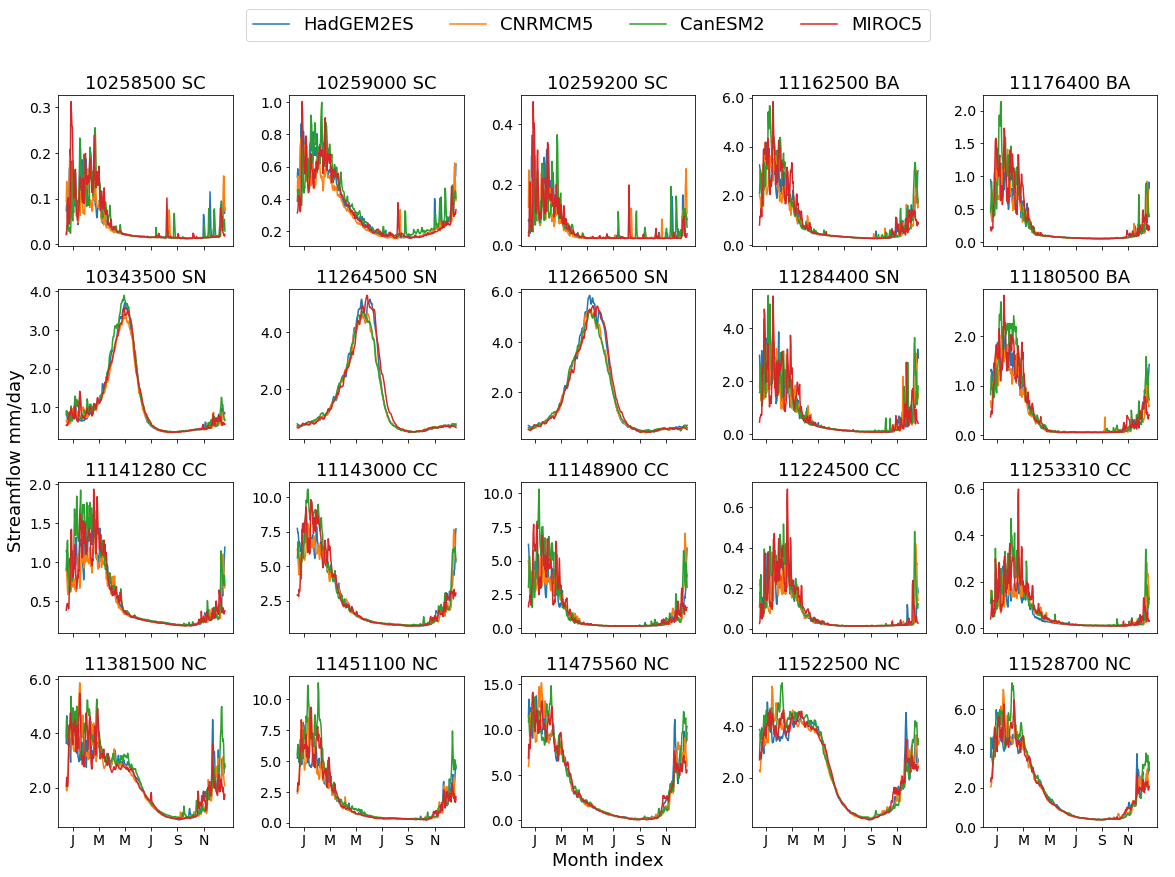

In [71]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Month index")
plt.ylabel("Streamflow mm/day")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0
for i in range(20):
    station = order_stations[i]
    for climate_model in climate_models:
        projection = np.load('projection_dataset/'+str(station)+'-'+climate_model+'-hist.npy')[1:]
        out, year = annual_mean(projection, Hist_date)
        # print(year)
        annual = out/year
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.flat[i].plot(annual, label=climate_model)
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('hist-climatology-four-models.eps')